In [3]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
import glob
from matplotlib import pyplot as plt
import cv2

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

diction = []
for i in range(1, 6):
    location = './cifar-10-batches-py/data_batch_' + str(i)
    diction.append(unpickle(location))

X_train = []
Y_train = []
X_test = []
Y_test = []
for i in range(5):
    for j in range(len(diction[i]['labels'])):
        X_train.append(diction[i]['data'][j])
        Y_train.append(diction[i]['labels'][j])

diction = unpickle('./cifar-10-batches-py/test_batch')
for j in range(len(diction['labels'])):
    X_test.append(diction['data'][j])
    Y_test.append(diction['labels'][j])

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)
print (np.unique(Y_train))

(50000, 3072) (50000,)
(10000, 3072) (10000,)
[0 1 2 3 4 5 6 7 8 9]


In [5]:
clf= GaussianNB()
clf= clf.fit(X_train, Y_train)
pred= clf.predict(X_test)
print ("The accuracy on test set as it is:- " + str((pred== Y_test).sum()/len(pred)))

The accuracy on test set as it is:- 0.2976


In [6]:
#cross validation
def cross_validation(X_train, Y_train, X_test, Y_test, k):#k is the number of folds
    a= np.arange(len(X_train))#input should be already projected data!
    clfs= []
    np.random.shuffle(a)
    breakpt= round((1/k)*len(X_train))
    valaccuracies= np.zeros(k)
    testaccuracies= np.zeros(k)
    for i in range(k):
        xx_train= []
        yy_train= []
        xx_val= []
        yy_val =[]
        for j in range(i*breakpt, min((i+1)*breakpt, len(X_train))):
            xx_val.append(X_train[a[j]])
            yy_val.append(Y_train[a[j]])
        for j in range(len(X_train)):
            if(j< i*breakpt or j>= (i+1)*breakpt):
                xx_train.append(X_train[a[j]])
                yy_train.append(Y_train[a[j]])
        
        clf= GaussianNB()
        clf= clf.fit(xx_train, yy_train)
        pred= clf.predict(xx_val)
        clfs.append(clf)
        acc= ((pred== yy_val).sum())/len(pred)
        valaccuracies[i]= acc
        pred2= clf.predict(X_test)
        acc2= ((pred2== Y_test).sum())/len(pred2)
        testaccuracies[i]= acc2
    
    print("The mean accuracy on the Validation set is: " + str(np.mean(valaccuracies)))
    print("The standard deviation of accuracies on the Validation set is: " + str(np.std(valaccuracies)))
    index= np.argmax(testaccuracies)
    print("The best model during C.V. gives accuracy of " + str(testaccuracies[index]) + " on the test set.")
    return clfs, index
        


In [7]:
def get_energy(w, eigenenergy):
    w= w/np.sum(w)
    -np.sort(-w)
    sum= 0
    k= 0
    for i in range(len(w)):
        if(sum< eigenenergy):
            k+= 1
            sum+= w[i]
        else:
            return k
    

In [8]:
def pca(X_train, eigenenergy):
    covmatrix= np.cov(X_train.T)
    print ("DOING PCA...")
    print (covmatrix.shape)
    #print (covmatrix)
    w, v= np.linalg.eig(covmatrix)
    w= np.abs(w)#should be spd and integers as well.
    v= v.real
#     print (w)
#     print (v)
    print (w.shape, v.shape)
    #for the sorting part
    dict= {}
    for i in range(len(w)):
        dict[i]= w[i]
    
    k= get_energy(w, eigenenergy)
    print (k)
    sorteddict= sorted(dict.items(), key=lambda kv: kv[1], reverse= True)
    W= np.zeros(shape= (len(v), k))
    for i in range(k):
        W[:, i]= v[:, sorteddict[i][0]]
    
    print (W.shape)
    #print (W)
    return W #already returns the transpose
    


In [9]:
def make_conf(probstest, Y_test):
    label= np.zeros(len(Y_test))
    for i in range(len(probstest)):
        index= np.argmax(probstest[i])#0to9
        label[i]= index
    
    uniq= np.unique(Y_test)
    confmatrix= np.zeros([len(uniq), len(uniq)])
#     print (label)
#     print (Y_test)
    for i in range(len(Y_test)):
        confmatrix[int(Y_test[i])][int(label[i])]+= 1
    
    df_cm = pd.DataFrame(confmatrix, index=[i for i in ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6',
                                                       'Class7', 'Class8', 'Class9', 'Class10']],
                         columns=[i for i in ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6',
                                                       'Class7', 'Class8', 'Class9', 'Class10']])
    plt.xlabel('Predicted Class')
    plt.ylabel("Actual Class")
    plt.title("Confusion matrix for PCA")
    sns.heatmap(df_cm, annot=True)
    plt.show()


In [10]:
def pca2(X_train, k):
    covmatrix= np.cov(X_train.T)
    print ("DOING PCA...")
    print (covmatrix.shape)
    #print (covmatrix)
    w, v= np.linalg.eig(covmatrix)
    w= np.abs(w)#should be spd and integers as well.
    v= v.real
#     print (w)
#     print (v)
    print (w.shape, v.shape)
    #for the sorting part
    dict= {}
    for i in range(len(w)):
        dict[i]= w[i]
    
    #k= get_energy(w, eigenenergy)
    print (k)
    sorteddict= sorted(dict.items(), key=lambda kv: kv[1], reverse= True)
    W= np.zeros(shape= (len(v), k))
    for i in range(k):
        W[:, i]= v[:, sorteddict[i][0]]
    
    print (W.shape)
    #print (W)
    return W #already returns the transpose
    


In [11]:
def lda(X_train, Y_train, k):
    Sw = np.zeros([len(X_train[0]), len(X_train[0])])
    print ("DOING LDA....")
    #print  (X_train[0])
    a = np.unique(Y_train)
    meanlist= np.zeros([len(a), len(X_train[0])])
    for i in a:
        meanlist[i-1]+= np.mean(X_train[Y_train == i], axis = 0)
    
#     print (meanlist[0])
#     print (meanlist[1])
        
    for i in a:
        num = (X_train[Y_train == i].shape[0])
        thisisis = np.cov(X_train[Y_train == i].T)*num
        Sw += thisisis
    #print (Sw)
    
    globalmu= np.mean(X_train, axis= 0)
    #print (globalmu.shape)
    #print (meanlist.shape)
    
    Sb = np.zeros([len(X_train[0]), len(X_train[0])])
    for i in a:
        num = (X_train[Y_train == i].shape[0])
        print ("shape: ", X_train[Y_train == i].shape)
        Sb+= np.outer((meanlist[i-1] - globalmu), (meanlist[i-1] - globalmu).T)*num
    
    print (Sb.shape, Sw.shape)
    #print(Sb)
    
    w, v= np.linalg.eig(np.dot(np.linalg.inv(Sw), Sb))
#     print (w)
    w= np.abs(w)
    v= v.real
    print (w.shape, v.shape)
    dict= {}
    for i in range(len(w)):
        dict[i]= w[i]
        
    #k= get_energy(w, eigenenergy)
    
    sorteddict= sorted(dict.items(), key=lambda kv: kv[1], reverse= True)
    W= np.zeros(shape= (len(v), k))
    for i in range(k):
        W[:, i]= v[:, sorteddict[i][0]]
    
    print (W.shape)
    return W


In [ ]:
Wpca= pca(X_train, 0.90)#88  with 0.99 eigenenergy
#eigenfaces for upto 2 dimensions for 0.95 eigenenergy
#plt.figure(figsize= (7, 6))
# for i in range(Wpca.shape[1]):
#     eigenvector= Wpca[:, i]
#     eigenvector= eigenvector.reshape(64, 48)
#     print (eigenvector.shape)
#     plt.imshow(eigenvector)
#     plt.show()

# for i in range(Wpca.shape[1]):
#     eig= np.zeros(2)
#     eig[0]= Wpca[0][i]
#     eig[1]= Wpca[1][i]
#     eig= eig/(np.sqrt(eig[0]**2 + eig[1]**2))
#     #print (eig)
#     plt.plot([0, eig[0]], [0, eig[1]])

# plt.xlabel('1st Dimension')
# plt.ylabel('2nd Dimension')
# plt.title('Eigenvectors for PCA visualised')
# plt.show()

In [ ]:
X_trainpca= []
X_testpca= []
for i in range(len(X_train)):
    X_trainpca.append(np.dot(X_train[i], Wpca))

for i in range(len(X_test)):
    X_testpca.append(np.dot(X_test[i], Wpca))

print(len(X_trainpca), len(X_trainpca[0]))
gnb= GaussianNB()
Y_pred1= gnb.fit(X_trainpca, Y_train).predict(X_testpca)
print (len(Y_pred1))
print (((Y_pred1== Y_test).sum())/len(Y_test))



In [ ]:
#ROC for PCA!
clfs, index= cross_validation(X_trainpca, Y_train, X_testpca, Y_test, 5)
print (index)
clf= clfs[index]
thresholds= [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,  0.65,  0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
# print(pred)
probstest= clf.predict_proba(X_testpca)#returns 211*11 matrix
print (probstest.shape)
uniq= np.unique(Y_train)
for i in range(len(uniq)):
    print (str(i) + " class loop!")
    tprtest= []
    fprtest= []
    for threshold in thresholds:
        confmatrix= np.zeros([2,2])
        label= np.zeros(len(X_test))
        for j in range(len(X_test)):
            if(probstest[j][i]>= threshold):
                label[j]= i+1
        
        for j in range(len(Y_test)):
            if(Y_test[j]== i+1 and label[j]== i+1):
                confmatrix[0][0]+= 1
            elif(Y_test[j]!= i+1 and label[j]!= i+1):
                confmatrix[1][1]+= 1
            elif(Y_test[j]== i+1 and label[j]!= i+1):
                confmatrix[0][1]+= 1#fn
            elif(Y_test[j]!= i+1 and label[j]== i+1):
                confmatrix[1][0]+= 1#fp
        
        tprtest.append(confmatrix[0][0]/(confmatrix[0][0] + confmatrix[0][1]))
        fprtest.append(confmatrix[1][0]/(confmatrix[1][0] + confmatrix[1][1]))
    
    label= "Class " + str(i+1)
    plt.plot(fprtest, tprtest, label= label)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for PCA")
plt.legend(loc= 'lower right')
plt.show()


In [ ]:
make_conf(probstest, Y_test)

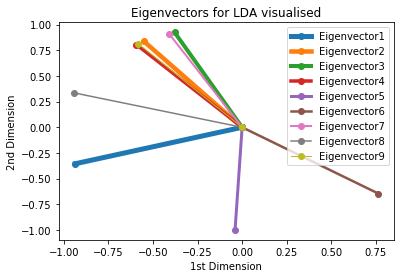

In [13]:
Wlda= lda(X_train, Y_train, 9)#equivalent to 0.99 eigenenergy

width= 5
for i in range(Wlda.shape[1]):
    eig= np.zeros(2)
    eig[0]= Wlda[0][i]
    eig[1]= Wlda[1][i]
    eig= eig/(np.sqrt(eig[0]**2 + eig[1]**2))
    #print (eig)
    plt.plot([0, eig[0]], [0, eig[1]], marker= 'o', linewidth= width, label= 'Eigenvector' + str(i+1))
    width-= 0.5

plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.legend(loc= 'upper right')
plt.title('Eigenvectors for LDA visualised')
plt.show()

In [ ]:
X_trainlda= []
X_testlda= []
for i in range(len(X_train)):
    X_trainlda.append(np.dot(X_train[i], Wlda))
for i in range(len(X_test)):
    X_testlda.append(np.dot(X_test[i], Wlda))

print(len(X_trainlda), len(X_trainlda[0]))
gnb= GaussianNB()
Y_pred2= gnb.fit(X_trainlda, Y_train).predict(X_testlda)
#print (Y_pred2)



In [ ]:
print ((Y_pred2== Y_test).sum()/len(Y_test))

In [ ]:
#Wlda= lda(X_train, Y_train, 0.90)
for i in range(10):
    temp= X_train[Y_train== i]
    projected= []
    for j in range(len(temp)):
        projected.append(np.dot(temp[j], Wlda))
    
    projected= np.array(projected)
    print (projected.shape)
    label= "Class " + str(i)
    plt.scatter(projected[:, 0], projected[:, 1], label= label)

plt.xlabel("1st Dimension")
plt.ylabel("2nd Dimension")
plt.title("Projected Data over 2 Dimensions")
plt.legend(loc= 'lower left')
plt.show()


In [ ]:
clfs, index= cross_validation(X_trainlda, Y_train, X_testlda, Y_test, 5)
print (index)
clf= clfs[index]
thresholds= [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,  0.65,  0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
# print(pred)
probstest= clf.predict_proba(X_testlda)#returns 211*11 matrix
print (probstest.shape)
uniq= np.unique(Y_train)
for i in range(len(uniq)):
    print (str(i) + " class loop!")
    tprtest= []
    fprtest= []
    for threshold in thresholds:
        confmatrix= np.zeros([2,2])
        label= np.zeros(len(X_test))
        for j in range(len(X_test)):
            if(probstest[j][i]>= threshold):
                label[j]= i+1
        
        for j in range(len(Y_test)):
            if(Y_test[j]== i+1 and label[j]== i+1):
                confmatrix[0][0]+= 1
            elif(Y_test[j]!= i+1 and label[j]!= i+1):
                confmatrix[1][1]+= 1
            elif(Y_test[j]== i+1 and label[j]!= i+1):
                confmatrix[0][1]+= 1#fn
            elif(Y_test[j]!= i+1 and label[j]== i+1):
                confmatrix[1][0]+= 1#fp
        
        tprtest.append(confmatrix[0][0]/(confmatrix[0][0] + confmatrix[0][1]))
        fprtest.append(confmatrix[1][0]/(confmatrix[1][0] + confmatrix[1][1]))
    
    label= "Class " + str(i+1)
    plt.plot(fprtest, tprtest, label= label)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LDA")
plt.legend(loc= 'lower right')
plt.savefig('Roc_LDA.png', dpi= 350)
plt.show()


In [ ]:
make_conf(probstest, Y_test)

In [ ]:
#LDA over PCA projected data (makes sense)
X_trainpca= np.array(X_trainpca)
X_trainpca= X_trainpca.astype(int)
Wlda2= lda(X_trainpca, Y_train, 9)
X_trainlda= []
X_testlda= []
for i in range(len(X_train)):
    X_trainlda.append(np.dot(X_trainpca[i], Wlda2))
for i in range(len(X_test)):
    X_testlda.append(np.dot(X_testpca[i], Wlda2))

print(len(X_trainlda), len(X_trainlda[0]))
gnb= GaussianNB()
Y_pred2= gnb.fit(X_trainlda, Y_train).predict(X_testlda)
#print (Y_pred2)
print ((Y_pred2== Y_test).sum()/len(Y_test))



In [ ]:
#PCA over LDA projected data!
Wlda= lda(X_train, Y_train, 9)
X_trainlda= []
X_testlda= []
for i in range(len(X_train)):
    X_trainlda.append(np.dot(X_train[i], Wlda))
for i in range(len(X_test)):
    X_testlda.append(np.dot(X_test[i], Wlda))

X_trainlda= np.array(X_trainlda)
X_testlda= np.array(X_testlda)
Wpca= pca2(X_trainlda, 9)
X_trainpca= []
X_testpca= []
for i in range(len(X_train)):
    X_trainpca.append(np.dot(X_trainlda[i], Wpca))
for i in range(len(X_test)):
    X_testpca.append(np.dot(X_testlda[i], Wpca))

print(len(X_trainlda), len(X_trainlda[0]))
gnb= GaussianNB()
Y_pred= gnb.fit(X_trainlda, Y_train).predict(X_testlda)
#print (Y_pred2)
print ((Y_pred== Y_test).sum()/len(Y_test))
